In [1]:
"""
Notes on this model: https://shizacharania.notion.site/FCN-Fully-Convolutional-Network-bbc70d47ad92491cb534e2987ac7eb48

class convBlock (because you have 6 so its more feasible)
  - conv3d 3x3 (increase channels)
  - relu
  - conv3d 3x3 (same channels)
  - relu
  - max pool = conv with same channels, but stride is 2 and kernel is 2 (just like max pool layer)

  ~~~~~~~~~~~~~~~~~~

  - convtranspose3d = deconv increased channels, but stride is 2 and kernel is 3 (combining steps) - this is approach one
 
  ~~~~~~~~~~~~~~~~~~

  approach 2:
  - convtranspose3d = deconv with same channels, but stride is 2 and kernel is 2 (to increase spatial size)
  - conv 3x3 (less channels)

  ~~~~~~~~~~~~~~~~~~

  torch.add - for element wise summation
"""

'\nNotes on this model: https://shizacharania.notion.site/FCN-Fully-Convolutional-Network-bbc70d47ad92491cb534e2987ac7eb48\n\nclass convBlock (because you have 6 so its more feasible)\n  - conv3d 3x3 (increase channels)\n  - relu\n  - conv3d 3x3 (same channels)\n  - relu\n  - max pool = conv with same channels, but stride is 2 and kernel is 2 (just like max pool layer)\n\n  ~~~~~~~~~~~~~~~~~~\n\n  - convtranspose3d = deconv increased channels, but stride is 2 and kernel is 3 (combining steps) - this is approach one\n \n  ~~~~~~~~~~~~~~~~~~\n\n  approach 2:\n  - convtranspose3d = deconv with same channels, but stride is 2 and kernel is 2 (to increase spatial size)\n  - conv 3x3 (less channels)\n\n  ~~~~~~~~~~~~~~~~~~\n\n  torch.add - for element wise summation\n'

In [2]:
import torch
import torch.nn as nn

In [3]:
class ConvBlockEncoder(nn.Module): # need to add nn.Module here
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.convblock1 = nn.Conv3d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
    self.convblock2 = nn.Conv3d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, padding=1)
    self.downsample = nn.Conv3d(in_channels=output_channels, out_channels=output_channels, kernel_size=2, stride=2)

  def forward(self, x): # x represents the input
    x = self.convblock1(x)
    x = self.relu(x)
    x = self.convblock2(x)
    out = self.relu(x)
    down_out = self.downsample(out)
    return out, down_out # out is before downsamping and down_out is after

class ConvBlockDecoder(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()
    # self.deconv = nn.ConvTranspose3d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=2, padding=1, dilation=1)
    self.upsample = nn.ConvTranspose3d(in_channels=input_channels, out_channels=input_channels, kernel_size=2, stride=2)
    self.convblock = nn.Conv3d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, padding=1)

  def forward(self, x):
    # x = self.deconv(x) # didn't work because it was just outputing 7 or 9 as the amount of channels and I coulnd't change the padding because it would either have one extra or one less (and I wanted 8 as the spatial dimensions)
    x = self.upsample(x)
    x = self.convblock(x)
    return x


class FCN(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    # 4, 128, 128, 128
    # print(input_shape)
    self.nimages, self.channels, self.w, self.h, self.d = input_shape
    self.block1 = ConvBlockEncoder(4, 64)
    self.block2 = ConvBlockEncoder(64, 128)
    self.block3 = ConvBlockEncoder(128, 256)
    self.block4 = ConvBlockEncoder(256, 512)
    self.block5 = ConvBlockEncoder(512, 1024)
    self.block6 = ConvBlockEncoder(1024, 2048)

    self.block7 = ConvBlockDecoder(2048, 1024)
    self.block8 = ConvBlockDecoder(1024, 512)
    self.block9 = ConvBlockDecoder(512, 256)
    self.block10 = ConvBlockDecoder(256, 128)
    self.block11 = ConvBlockDecoder(128, 64)

    self.conv1by1 = nn.Conv3d(in_channels=64, out_channels=3, kernel_size=1, stride=1) # output is 3 channels for WT, ET, TC
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, x):
    # print("Before shape: ", str(x.shape))
    out1, down_out1 = self.block1(x)
    # print(out1.shape, down_out1.shape)

    out2, down_out2 = self.block2(down_out1)
    # print(out2.shape, down_out2.shape)

    out3, down_out3 = self.block3(down_out2)
    # print(out3.shape, down_out3.shape)

    out4, down_out4 = self.block4(down_out3)
    # print(out4.shape, down_out4.shape)

    out5, down_out5 = self.block5(down_out4)
    # print(out5.shape, down_out5.shape)

    out6, ____ = self.block6(down_out5)
    # print(out6.shape)

    out7 = self.block7(out6)
    # print(out7.shape)

    # sum here with block 5 + block 7
    out57 = torch.add(out5, out7)
    # print(out57.shape)

    out8 = self.block8(out57)
    # print(out8.shape)
    
    # sum here with block 4 + block 8
    out48 = torch.add(out4, out8)
    # print(out48.shape)

    out9 = self.block9(out48)
    # print(out9.shape)

    out10 = self.block10(out9)
    # print(out10.shape)

    out11 = self.block11(out10)
    # print(out11.shape)

    out12 = self.conv1by1(out11)
    # print(out12.shape)

    # end = self.softmax(out12)
    # print(end.shape) # i thought that the shape would change when using softmax, but only the values change to add up to 1

    return out12

In [4]:
x = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
# print(x.shape)

model = FCN(x.shape)
print(model)
print()

out = model(x)

FCN(
  (block1): ConvBlockEncoder(
    (convblock1): Conv3d(4, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu): ReLU()
    (convblock2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (downsample): Conv3d(64, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  )
  (block2): ConvBlockEncoder(
    (convblock1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu): ReLU()
    (convblock2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (downsample): Conv3d(128, 128, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  )
  (block3): ConvBlockEncoder(
    (convblock1): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu): ReLU()
    (convblock2): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (downsample): Conv3d(256, 256, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  )
  (block4): ConvBlockEncoder(
    (convblock1)

In [5]:
print(out.shape)
print(out)

torch.Size([1, 3, 128, 128, 128])
tensor([[[[[-0.0454, -0.0454, -0.0446,  ..., -0.0454, -0.0448, -0.0481],
           [-0.0480, -0.0439, -0.0450,  ..., -0.0444, -0.0446, -0.0463],
           [-0.0475, -0.0451, -0.0446,  ..., -0.0451, -0.0448, -0.0467],
           ...,
           [-0.0477, -0.0439, -0.0449,  ..., -0.0445, -0.0448, -0.0464],
           [-0.0475, -0.0449, -0.0448,  ..., -0.0449, -0.0449, -0.0467],
           [-0.0460, -0.0458, -0.0457,  ..., -0.0461, -0.0457, -0.0461]],

          [[-0.0465, -0.0464, -0.0469,  ..., -0.0463, -0.0468, -0.0475],
           [-0.0448, -0.0420, -0.0405,  ..., -0.0418, -0.0404, -0.0422],
           [-0.0448, -0.0418, -0.0421,  ..., -0.0416, -0.0421, -0.0424],
           ...,
           [-0.0448, -0.0423, -0.0406,  ..., -0.0420, -0.0405, -0.0423],
           [-0.0445, -0.0415, -0.0416,  ..., -0.0413, -0.0419, -0.0424],
           [-0.0440, -0.0438, -0.0424,  ..., -0.0436, -0.0424, -0.0420]],

          [[-0.0459, -0.0474, -0.0463,  ..., -0.0473, 

In [6]:
"""
- SGD
- minibatch size = 20
- learning rates of 10^-3 (fcn-alexNet), **10^-4 (fcn-vgg16- use this initially because the paper said the model is “our VGG-16 based net)**, ^-5 (fcn-googlelenet)
- momentum = 0.9
- weight decay = 5^-4 or 2^-4

- dropout was included where used in the original classifier nets
- didn’t choose patches because although it has a better convergence rate compared to the whole image training, it takes significantly more time because of the larger numbers that need to be considered per batch
- data augmentation of randomly mirroring and “jittering” the images by translating them up to 32 pixels
- Nvidia Tesla K40 GPU
- metrics (testing)
"""

'\n- SGD\n- minibatch size = 20\n- learning rates of 10^-3 (fcn-alexNet), **10^-4 (fcn-vgg16- use this initially because the paper said the model is “our VGG-16 based net)**, ^-5 (fcn-googlelenet)\n- momentum = 0.9\n- weight decay = 5^-4 or 2^-4\n\n- dropout was included where used in the original classifier nets\n- didn’t choose patches because although it has a better convergence rate compared to the whole image training, it takes significantly more time because of the larger numbers that need to be considered per batch\n- data augmentation of randomly mirroring and “jittering” the images by translating them up to 32 pixels\n- Nvidia Tesla K40 GPU\n- metrics (testing)\n'

In [7]:
import numpy as np

In [8]:
randomized_training_images = []
for i in range(2):
  newx = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_training_images.append(newx)

In [9]:
print(len(randomized_training_images))
print(randomized_training_images[0].shape)
# print(randomized_training_images[0])

2
torch.Size([1, 4, 128, 128, 128])


In [10]:
randomized_training_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_training_segmentations.append(newy)

In [11]:
print(len(randomized_training_segmentations))
print(randomized_training_segmentations[0].shape)
# print(randomized_training_segmentations[1])

2
torch.Size([1, 3, 128, 128, 128])


In [12]:
randomized_training_data = list(zip(randomized_training_images, randomized_training_segmentations))

In [13]:
trainloader = torch.utils.data.DataLoader(dataset=randomized_training_data, batch_size=2, shuffle=True) # minibatch size should be 20

In [14]:
len(trainloader)

1

In [15]:
randomized_validation_images = []
for i in range(2):
  newy = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_validation_images.append(newy)

In [16]:
print(len(randomized_validation_images))
print(randomized_validation_images[0].shape)

2
torch.Size([1, 4, 128, 128, 128])


In [17]:
randomized_validation_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_validation_segmentations.append(newy)

In [18]:
print(len(randomized_validation_segmentations))
print(randomized_validation_segmentations[0].shape)

2
torch.Size([1, 3, 128, 128, 128])


In [19]:
randomized_validation_data = list(zip(randomized_validation_images, randomized_validation_segmentations))

In [20]:
validationloader = torch.utils.data.DataLoader(dataset=randomized_validation_data, batch_size=2, shuffle=True) # minibatch size should be 20

In [21]:
len(validationloader)

1

In [22]:
randomized_testing_images = []
for i in range(2):
  newy = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_testing_images.append(newy)

In [23]:
print(len(randomized_testing_images))
print(randomized_testing_images[0].shape)

2
torch.Size([1, 4, 128, 128, 128])


In [24]:
randomized_testing_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_testing_segmentations.append(newy)

In [25]:
print(len(randomized_testing_segmentations))
print(randomized_testing_segmentations[0].shape)

2
torch.Size([1, 3, 128, 128, 128])


In [26]:
randomized_testing_data = list(zip(randomized_testing_images, randomized_testing_segmentations))

In [27]:
testingloader = torch.utils.data.DataLoader(dataset=randomized_testing_data, batch_size=2, shuffle=True) # same size as testing dataset

In [28]:
# batch size should be one or the entire size of the dataset:
# https://stackoverflow.com/questions/54413160/training-validation-testing-batch-size-ratio
# https://vijayabhaskar96.medium.com/validation-set-can-have-the-same-batch-size-as-your-training-set-only-the-final-dataset-that-you-824679aca3f9

In [29]:
"""
Training + Validation:
categorical cross entropy loss (nn.CrossEntropyLoss())

Testing:
(update)
"""

'\nTraining + Validation:\ncategorical cross entropy loss (nn.CrossEntropyLoss())\n\nTesting:\n(update)\n'

In [30]:
import torch.optim

In [31]:
# epochs
epochs = 2
# loss
criterion = torch.nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=10**-4, momentum=0.9, weight_decay=5**-4)

In [32]:
import datetime

In [33]:
training_losses = [] # training losses over epochs
validation_losses = [] # validation losses over epochs

for i in range(epochs): # for every epoch
  start_epoch = datetime.datetime.now() # start the timer in datetime module
  training_loss = 0 # training loss for this epoch
  validation_loss = 0 # validation loss for this epoch
  print("training time")
  for images, segs in trainloader: # getting one batch from trainloader
    optimizer.zero_grad() # turn on gradients (used for forward and backprop)
    print(len(images), len(segs))
    print(images.shape)
    print(segs.shape)
    # need to squeeze the 1 in first dimension
    images = images.squeeze().clone().detach().requires_grad_(True)
    # segs = segs.long() - no
    segs = segs.squeeze().clone().detach().requires_grad_(True)
    print(images.shape)
    print(segs.shape)
    outputs = model(images) # put images through model
    print(outputs.shape)

    # arg_outputs = outputs.argmax(dim=1)
    # print(arg_outputs.shape)
    # print(arg_outputs)
    # print(segs.shape)
    print()
    loss = criterion(outputs.float(), segs) # calculate loss
    print(loss)
    
    # loss can be > 1 - https://ai.stackexchange.com/questions/24685/can-the-sparse-categorical-cross-entropy-be-greater-than-one, https://stats.stackexchange.com/questions/392681/cross-entropy-loss-max-value
    loss.backward() # back propagation
    training_loss += loss.item() # add loss to training loss
    print()
  print("validation time")
  
  for images, segs in validationloader: # getting one batch from validationloader
    optimizer.zero_grad() # keep gradients on (used for forward and backprop)
    print(len(images), len(segs))
    print(images.shape)
    print(segs.shape)
    # need to squeeze the 1 in first dimension
    images = images.squeeze().clone().detach().requires_grad_(True)
    # segs = segs.long() - no
    segs = segs.squeeze().clone().detach().requires_grad_(True)
    print(images.shape)
    print(segs.shape)
    outputs = model(images) # put images through model
    print(outputs.shape)
    print(segs.shape)
    print()
    loss = criterion(outputs.float(), segs) # calculate loss
    print(loss) 
    loss.backward() # backpropagation
    validation_loss += loss.item() # add loss to validation loss

  # find avg losses for each image
  training_losses.append(training_loss/len(trainloader)) 
  validation_losses.append(validation_loss/len(validationloader))

  # print results about epoch
  print("Epoch: {}/{}... Training Loss: {}... Validation Loss: {}...".format(i+1,epochs, training_losses[-1], validation_losses[-1]))
  if validation_loss < min(validation_losses): # save model if loss decreases
    print("Validation loss has decreased...saving model")
    torch.save(model.state_dict(), "fcn.pth") # save here
  
  # end timer
  end_epoch = datetime.datetime.now()
  # calculate and print out time it takes for every epoch
  time_epoch = end_epoch-start_epoch
  print("Epoch time:", str(time_epoch), "\n")

training time
2 2
torch.Size([2, 1, 4, 128, 128, 128])
torch.Size([2, 1, 3, 128, 128, 128])
torch.Size([2, 4, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])

tensor(1.6493, grad_fn=<DivBackward1>)

validation time
2 2
torch.Size([2, 1, 4, 128, 128, 128])
torch.Size([2, 1, 3, 128, 128, 128])
torch.Size([2, 4, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])

tensor(1.6486, grad_fn=<DivBackward1>)
Epoch: 1/2... Training Loss: 1.6493319272994995... Validation Loss: 1.6485720872879028...
Epoch time: 0:02:13.977197 

training time
2 2
torch.Size([2, 1, 4, 128, 128, 128])
torch.Size([2, 1, 3, 128, 128, 128])
torch.Size([2, 4, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])

tensor(1.6493, grad_fn=<DivBackward1>)

validation time
2 2
torch.Size([2, 1, 4, 128, 128, 128])
torch.Size([2, 1, 3, 128, 128, 128])
torch.Size([2, 4, 128, 128, 128])
torch.Size([2

In [34]:
print(training_losses)
print(validation_losses)

[1.6493319272994995, 1.6493322849273682]
[1.6485720872879028, 1.6485720872879028]


In [35]:
import matplotlib.pyplot as plt

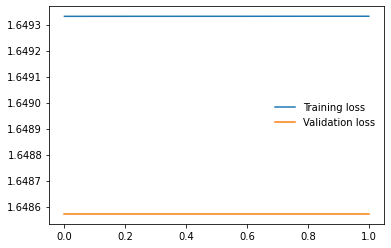

In [36]:
# visualize losses
plt.plot(training_losses, label="Training loss")
plt.plot(validation_losses, label="Validation loss")
plt.legend(frameon=False)

In [37]:
def pixel_accuracy(outputs, segmentations):
  # outputs = torch.Size([3, 128, 128, 128])
  # segmentations = torch.Size([3, 128, 128, 128])
  # print(torch.numel(segmentations))
  # print(torch.numel(segmentations[0]))
  # print()

  total_correct_pixels = 0
  total_num_pixels = 0
  for i in range(outputs.shape[0]): # for every image
    # class x torch.Size([128, 128, 128])
    # print(i)
    # print(outputs[i].shape)
    # print(segmentations[i].shape)
    correct_pixels = (outputs[i] == segmentations[i]).sum() # find total number of pixels where output == seg
    num_pixels = torch.numel(segmentations[i]) # find total number of pixels in prediction
    # print(correct_pixels.item())
    # print(num_pixels)
    total_correct_pixels += correct_pixels.item()
    total_num_pixels += num_pixels

  # print()
  # print(total_correct_pixels)
  # print(total_num_pixels)
  pixel_acc = (int(total_correct_pixels)/int(total_num_pixels)) # divide correct/total
  # print(pixel_acc)
  return pixel_acc

In [38]:
def mean_accuracy(outputs, segmentations):
  # outputs = torch.Size([3, 128, 128, 128])
  # segmentations = torch.Size([3, 128, 128, 128])
  n_classes = outputs.shape[0]
  total_mean_accuracies = 0
  for i in range(n_classes):
    # print(i)
    # print(outputs[i].shape)
    # print(segmentations[i].shape)
    correct_pixels = (outputs[i] == segmentations[i]).sum() # find total number of pixels where output == seg
    num_pixels = torch.numel(segmentations[i]) # find total number of pixels in prediction
    # print(correct_pixels.item())
    # print(num_pixels)
    mean_acc_classx = (int(correct_pixels)/int(num_pixels))
    # print(mean_acc_classx)
    total_mean_accuracies += mean_acc_classx
  # print()
  # print(total_mean_accuracies)
  final_mean_accuracy = total_mean_accuracies/n_classes
  return final_mean_accuracy

In [39]:
# IoU - find it per class and then do the mean
def mean_IoU(outputs, segmentations):
  # outputs = torch.Size([3, 128, 128, 128])
  # segmentations = torch.Size([3, 128, 128, 128])
  n_classes = outputs.shape[0]
  total_mean_iou = 0
  for i in range(n_classes):
    print(i)
    print(outputs[i].shape)
    print(segmentations[i].shape)

    # when you have a size of (BATCH x H x W) shape, then when you do .sum(), the dim should be [1,2]
    # this means that, when you have (BATCH x H x W x D), where batch is 1 so it doesn't count, you would do [0,1,2]
    intersection = torch.sum(torch.abs(outputs[i]*segmentations[i]), dim=[0,1,2]) # will be zero if Truth=0 or Prediction=0
    union = torch.sum(outputs, dim=[1,2,3]) + torch.sum(outputs, dim=[1,2,3]) - intersection  # will be zero if both are 0
    iou = torch.mean(intersection/union)
    total_mean_iou += iou
  print()
  print(total_mean_iou)
  final_mean_iou = total_mean_iou/n_classes
  return final_mean_iou

In [40]:
def frequency_weighted_IoU(outputs, segmentations):
  # outputs = torch.Size([3, 128, 128, 128])
  # segmentations = torch.Size([3, 128, 128, 128])
  n_classes = outputs.shape[0]
  total_mean_iou = 0
  for i in range(n_classes):
    # print(i)
    # print(outputs[i].shape)
    # print(segmentations[i].shape)

    # when you have a size of (BATCH x H x W) shape, then when you do .sum(), the dim should be [1,2]
    # this means that, when you have (BATCH x H x W x D), where batch is 1 so it doesn't count, you would do [0,1,2]
    intersection = torch.sum(torch.abs(outputs[i]*segmentations[i]), dim=[0,1,2]) # will be zero if Truth=0 or Prediction=0
    union = torch.sum(outputs, dim=[1,2,3]) + torch.sum(outputs, dim=[1,2,3]) - intersection  # will be zero if both are 0
    num_pixels = torch.numel(segmentations[i]) # find total number of pixels in prediction
    iou = torch.mean(intersection/num_pixels-union)*num_pixels # modification: multiplied this by the number of pixels in each class
    total_mean_iou += iou
  # print()
  # print(total_mean_iou)
  final_mean_iou = total_mean_iou/n_classes
  return final_mean_iou

In [41]:
# total_pixels = 0
# correct_pixels = 0

for images, segs in testingloader:
    with torch.no_grad(): # no gradients (there's no backprop, only evaluation)
      print(len(images), len(segs))
      print(images.shape)
      print(segs.shape)
      # exclude first dimension of 1
      images = images.squeeze().clone().detach().requires_grad_(True)
      # segs = segs.long() - no
      segs = segs.squeeze().clone().detach().requires_grad_(True)
      print(images.shape)
      print(segs.shape)
      outputs = model(images) # put images through model
      print(outputs.shape)
      print(segs.shape)
      print()
  
      print(len(outputs))
      print(outputs[0].shape)
      print(len(segs))
      print(segs[0].shape)
      print()

      print("......."*5)

      print("\nPIXEL ACCURACY METRIC")
      pixel_accuracy_metric = pixel_accuracy(outputs, segs) # IN DECIMAL
      print(pixel_accuracy_metric)
      print()
      # format after: print("Pixel Accuracy: during testing, the model correctly classified {}/{} pixels, with an accuracy of {:.2f}%".format(correct_pixels, total_pixels, accuracy))

      print("......."*5)

      print("\nMEAN ACCURACY METRIC")
      mean_accuracy_metric = mean_accuracy(outputs, segs) # IN DECIMAL
      print(mean_accuracy_metric)
      print()

      print("......."*5)

      print("\nMEAN IOU METRIC")
      mean_iou_metric = mean_accuracy(outputs, segs) # IN DECIMAL
      print(mean_iou_metric)
      print()

      print("......."*5)

      print("\nFREQUENCY WEIGHTED IOU METRIC")
      frequency_weighted_iou_metric = frequency_weighted_IoU(outputs, segs) # IN DECIMAL
      print(frequency_weighted_iou_metric)
      print()

2 2
torch.Size([2, 1, 4, 128, 128, 128])
torch.Size([2, 1, 3, 128, 128, 128])
torch.Size([2, 4, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])
torch.Size([2, 3, 128, 128, 128])

2
torch.Size([3, 128, 128, 128])
2
torch.Size([3, 128, 128, 128])

...................................

PIXEL ACCURACY METRIC
0.0

...................................

MEAN ACCURACY METRIC
0.0

...................................

MEAN IOU METRIC
0.0

...................................

FREQUENCY WEIGHTED IOU METRIC
tensor(5.2098e+10)

